In [4]:
import json
import pandas as pd
import numpy as np

In [5]:
data_players = pd.read_csv('dota2 matches/players.csv')
data_players.head()

data_matches = pd.read_csv('dota2 matches/match.csv')
data_matches.head()

data_teamfights = pd.read_csv('dota2 matches/teamfights.csv')
data_teamfights.head()

,match_id,start,end,last_death,deaths
0,0,220,252,237,3
1,0,429,475,460,3
2,0,900,936,921,3
3,0,1284,1328,1313,3
4,0,1614,1666,1651,5


In [6]:
#Grouping new data frame by match_id and collection all heroes together than split them by team
import time
start_time = time.time()


dire_data=data_players.groupby('match_id')['hero_id'].apply(list)
def divide_by_team(df, new_df):
    for j in range(df.shape[0]):
        new_r = list()
        for i in range(5):
            new_r.append(df[j].pop(df[j].index(df[j][0])))
        dictionnar={"Radiant_team":new_r}
        new_df = pd.concat([new_df, pd.DataFrame.from_dict(dictionnar)], ignore_index=True)
    return new_df


radiant_data = pd.DataFrame()
radiant_data = divide_by_team(dire_data, radiant_data)#--- 86.03843569755554 seconds ---

print("--- %s seconds ---" % (time.time() - start_time))#136.3190200328827 sec for split method

--- 23.30797028541565 seconds ---


In [7]:
print(radiant_data)

        Radiant_team
0                 86
1                 51
2                 83
3                 11
4                 67
...              ...
249995            94
249996            19
249997            68
249998            35
249999            21

[250000 rows x 1 columns]


In [8]:
data_matches['Radiant_team']=radiant_data
data_matches['Dire_team']=dire_data
data_matches.columns

Index(['match_id', 'start_time', 'duration', 'tower_status_radiant',
       'tower_status_dire', 'barracks_status_dire', 'barracks_status_radiant',
       'first_blood_time', 'game_mode', 'radiant_win', 'negative_votes',
       'positive_votes', 'cluster', 'Radiant_team', 'Dire_team'],
      dtype='object')

In [9]:
#Adding the mean_values of features which would be grouped by match_id
def adding_mean_values_of_diff_features_by_team(df,groupby,features,new_df):
    for i in range(len(features)):
        dire_data=df.groupby(groupby)[features[i]].apply(list)
        radiant_data=pd.DataFrame()
        radiant_data=divide_by_team(dire_data,radiant_data)
        radiant_data=radiant_data['Radiant_team'].apply(lambda x: sum(x)/len(x) if isinstance(x, list) else x)
        dire_data=dire_data.apply(lambda x :sum(x)/len(x))
        new_df[features[i]+'_radiant']=radiant_data
        new_df[features[i]+'_dire']=dire_data
    return new_df

In [10]:
features=['gold_spent','gold_per_min','xp_per_min','kills','deaths','tower_damage','hero_damage']
data_matches=adding_mean_values_of_diff_features_by_team(data_players,'match_id',features,data_matches)
print(data_matches.head())

   match_id  start_time  duration  tower_status_radiant  tower_status_dire  \
0         0  1446750112      2375                  1982                  4   
1         1  1446753078      2582                     0               1846   
2         2  1446764586      2716                   256               1972   
3         3  1446765723      3085                     4               1924   
4         4  1446796385      1887                  2047                  0   

   barracks_status_dire  barracks_status_radiant  first_blood_time  game_mode  \
0                     3                       63                 1         22   
1                    63                        0               221         22   
2                    63                       48               190         22   
3                    51                        3                40         22   
4                     0                       63                58         22   

   radiant_win  ...  xp_per_min_radiant  xp_

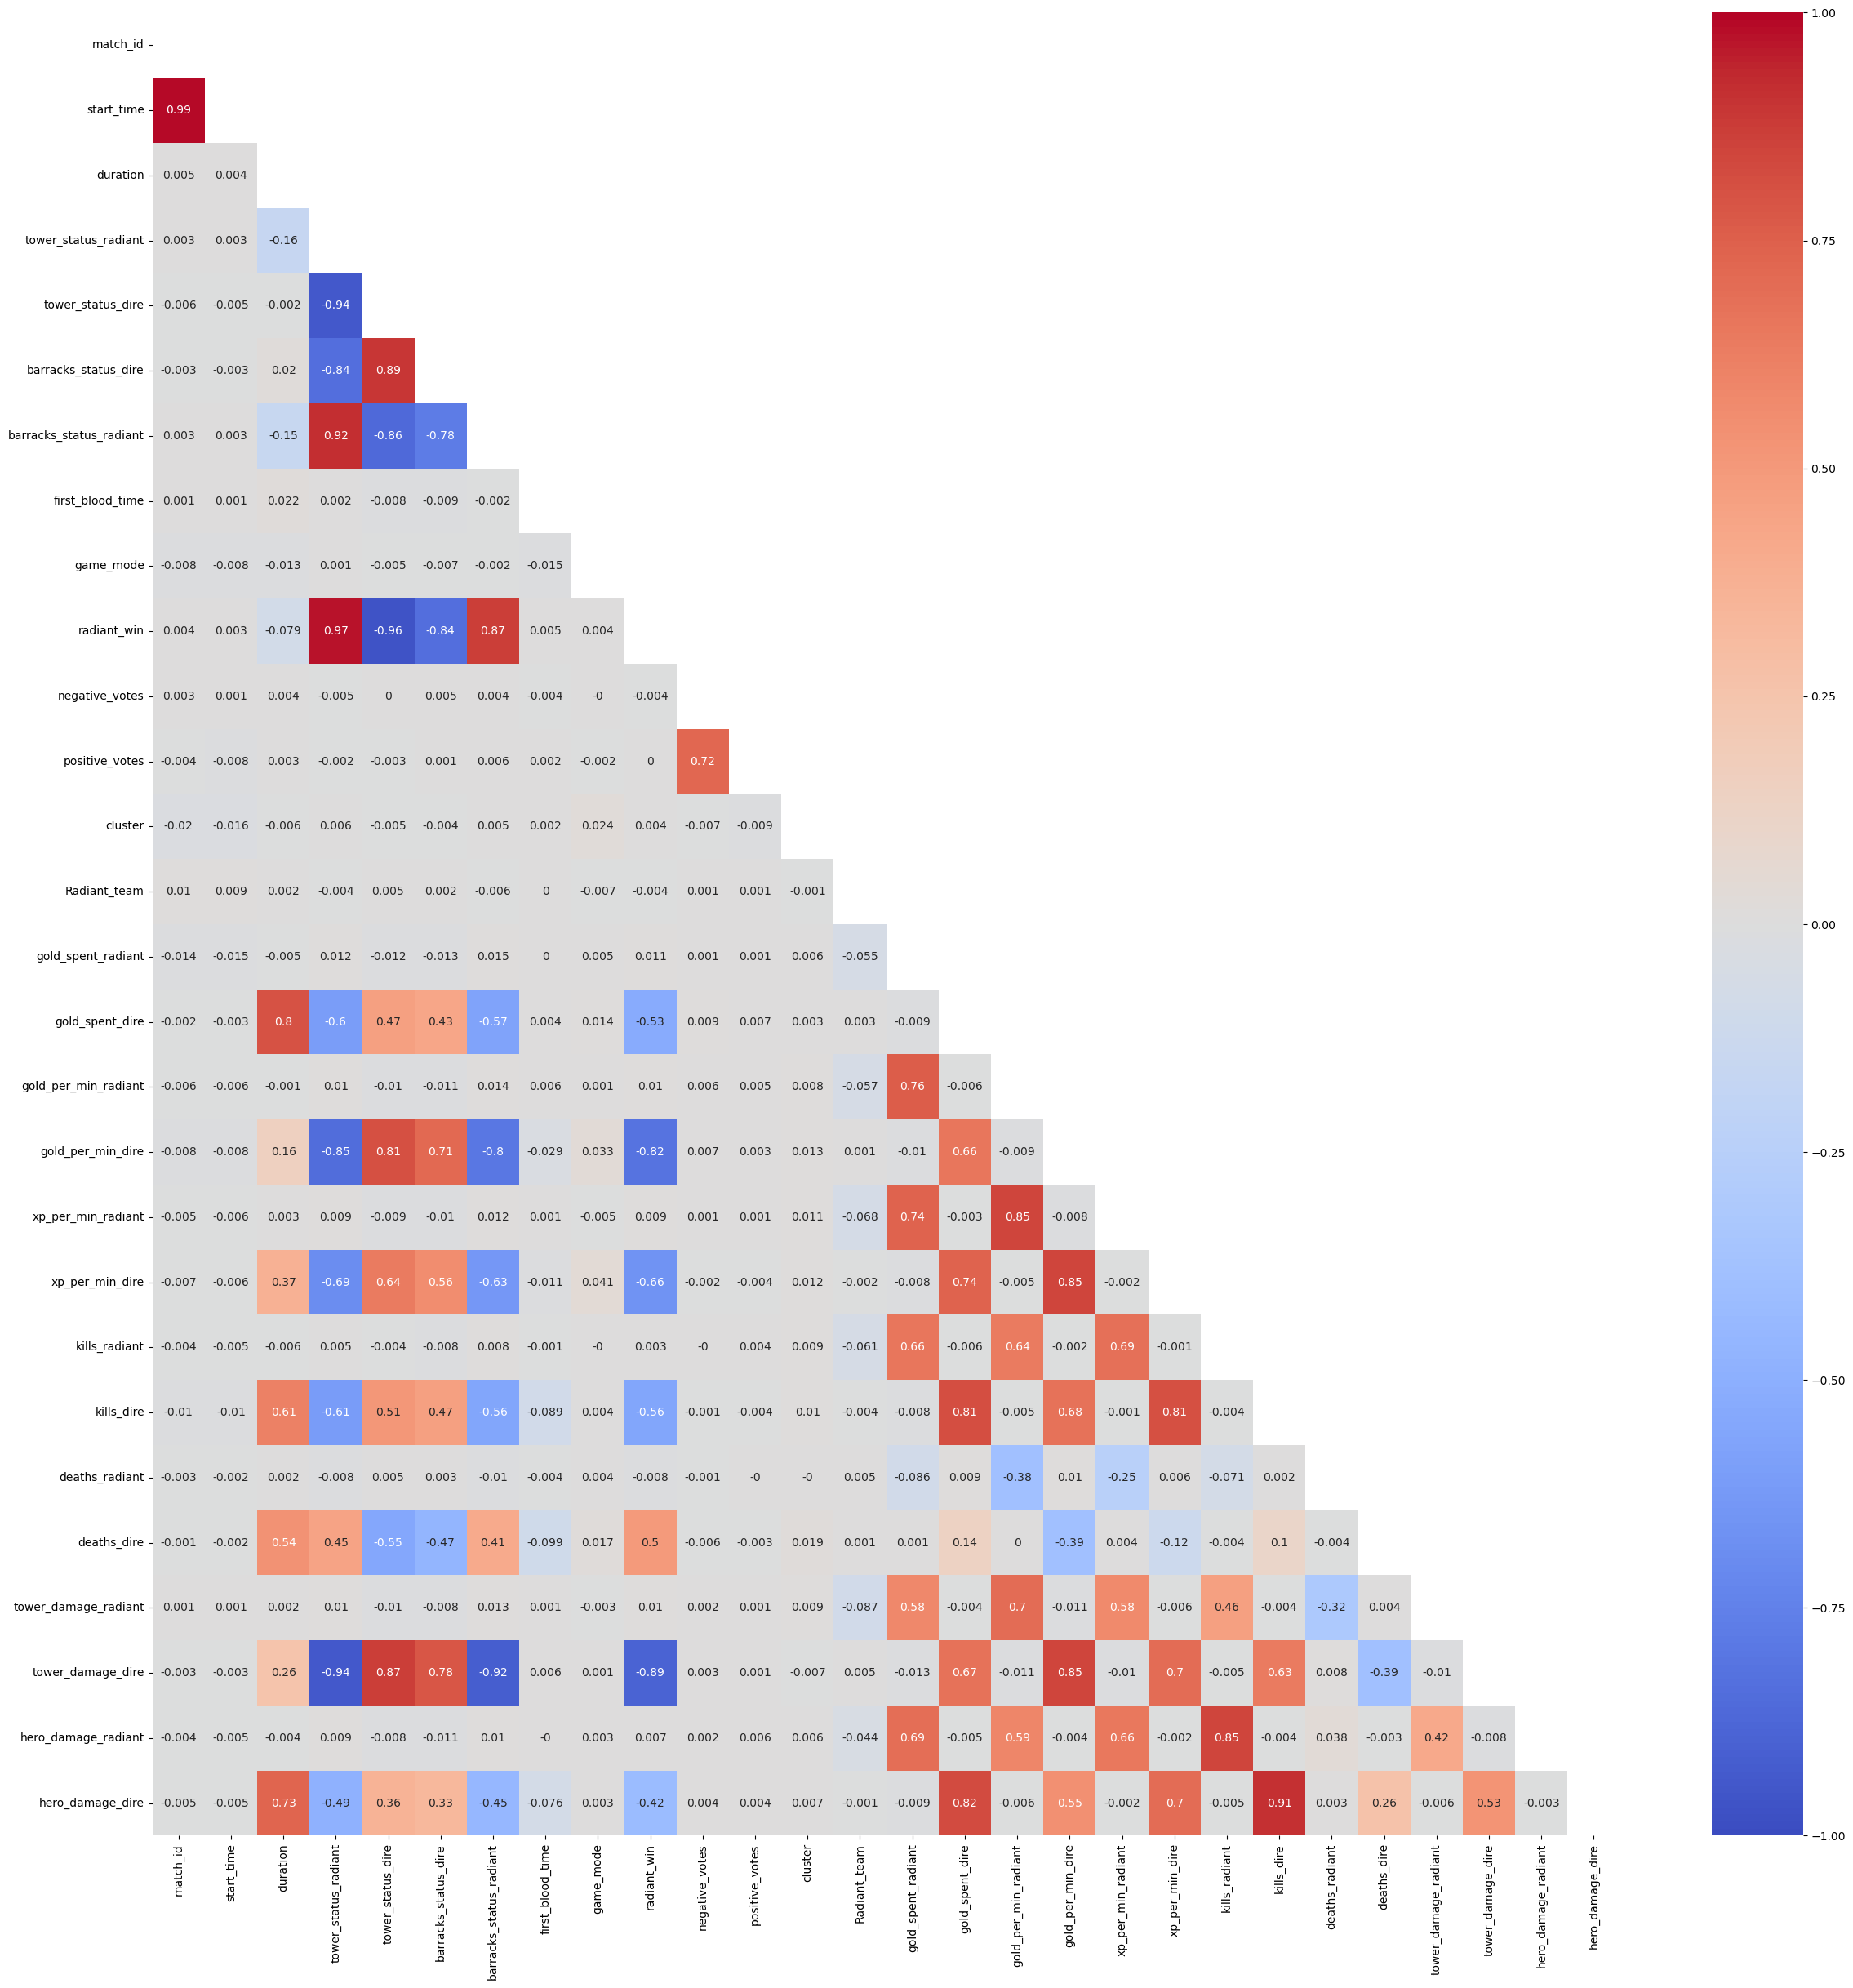

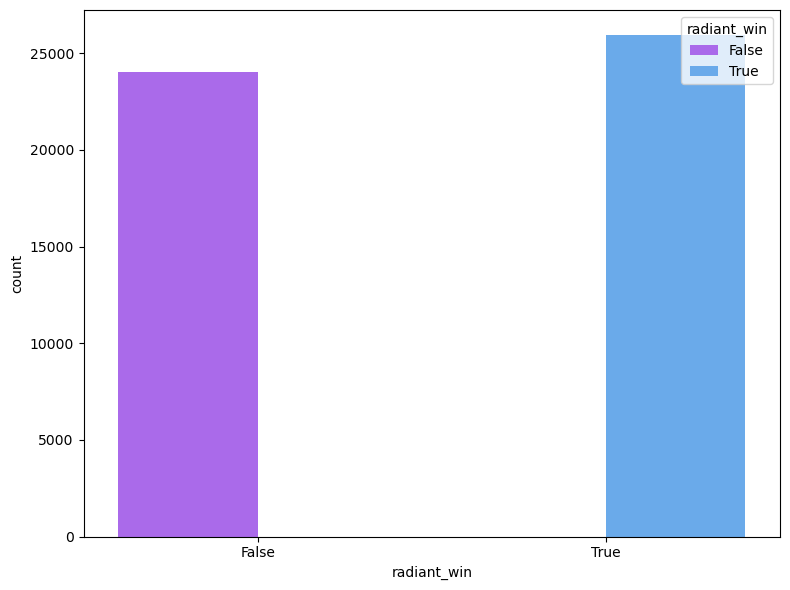

In [11]:
# Correlation between values and hist of wins
import matplotlib.pyplot as plt
import seaborn as sns
def corr_heatmap(df, digits=3, cmap='coolwarm'):

    # Create correlation matrix from dataframe
    correl = df.corr().round(digits)
    

    # Create mask for upper triangle of matrix
    mask = np.zeros_like(correl)
    
    
    mask[np.triu_indices_from(mask)] = True
    

    #Create heatmap correlation matrix
    fig, ax = plt.subplots(figsize=((len(df.columns)),(len(df.columns))))
    sns.heatmap(correl, annot=True, ax=ax, cmap=cmap, vmin=-1, vmax=1,\
                mask=mask);
    return fig, ax
corr_heatmap(data_matches)
fig, ax = plt.subplots(figsize=(8,6))
# sns.histplot(x='blueWins', data=diff_df, hue='blueWins', palette='Set1',bins=(2), kde=False)
sns.countplot(x='radiant_win', data=data_matches, hue='radiant_win', palette='cool_r')

# Save as image
plt.tight_layout()

In [12]:
from matplotlib.gridspec import GridSpec
def visual_eda(df, target, col):

    # Create copy variables of df and col
    data = df[col].copy()
    name = col

    # Calc mean and mean
    median = data.median()
    mean = data.mean()
    
    
    # Create gridspec for plots
    fig = plt.figure(figsize=(11, 6))
    gs = GridSpec(nrows=2, ncols=2)

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[:, 1])

    # Plot distribution 
    sns.histplot(data,alpha=0.5,stat='density',ax=ax0)
    sns.kdeplot(data,color='green',label='KDE',ax=ax0)
    ax0.set(ylabel='Density',title=name)
    ax0.set_title(F"Distribution of {name}")
    ax0.axvline(median,label=f'median={median:,}',color='black')
    ax0.axvline(mean,label=f'mean={mean:,}',color='black',ls=':')
    ax0.legend()

    # Plot Boxplot
    sns.boxplot(data,x=col,ax=ax1)
    ax1.set_title(F"Box Plot of {name}")

    # Plot Scatterplot to illustrate linearity
    sns.regplot(data=df, x=col, y=target, line_kws={"color": "red"}, ax=ax2)
    ax2.set_title(F"Scatter Plot of {name}")

    # Tweak Layout & Display
    fig.tight_layout()
   
    return fig, gs

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


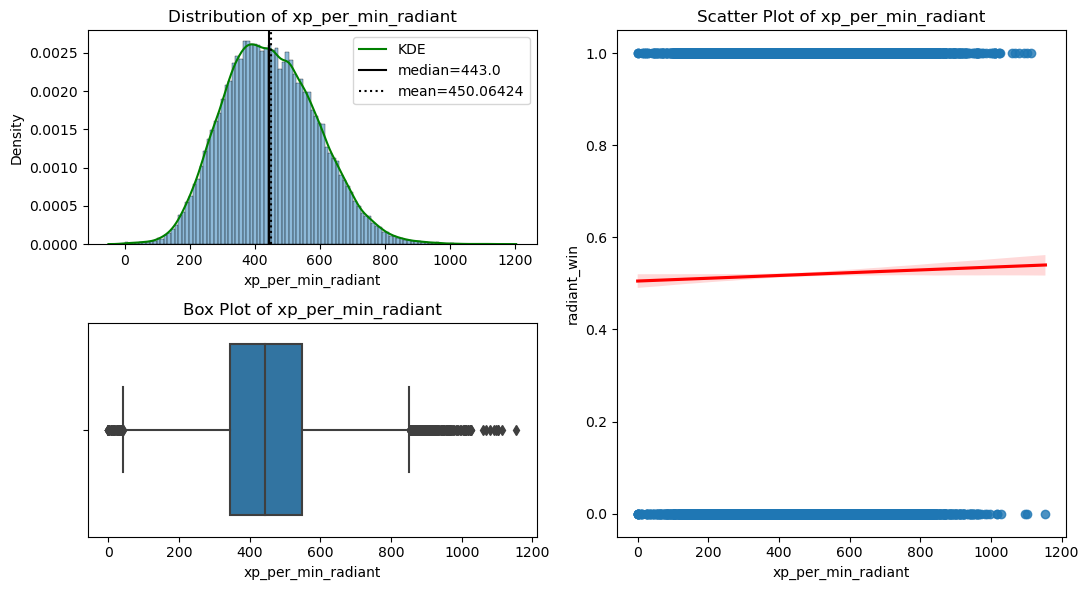

In [13]:
visual_eda(data_matches, 'radiant_win', 'xp_per_min_radiant');

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


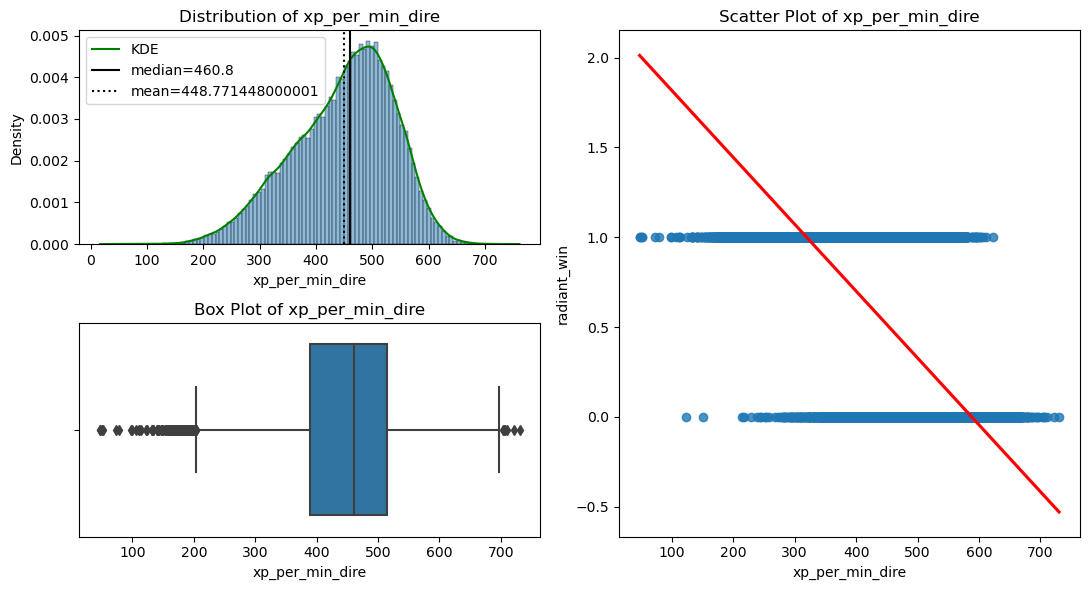

In [14]:
visual_eda(data_matches, 'radiant_win', 'xp_per_min_dire');

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


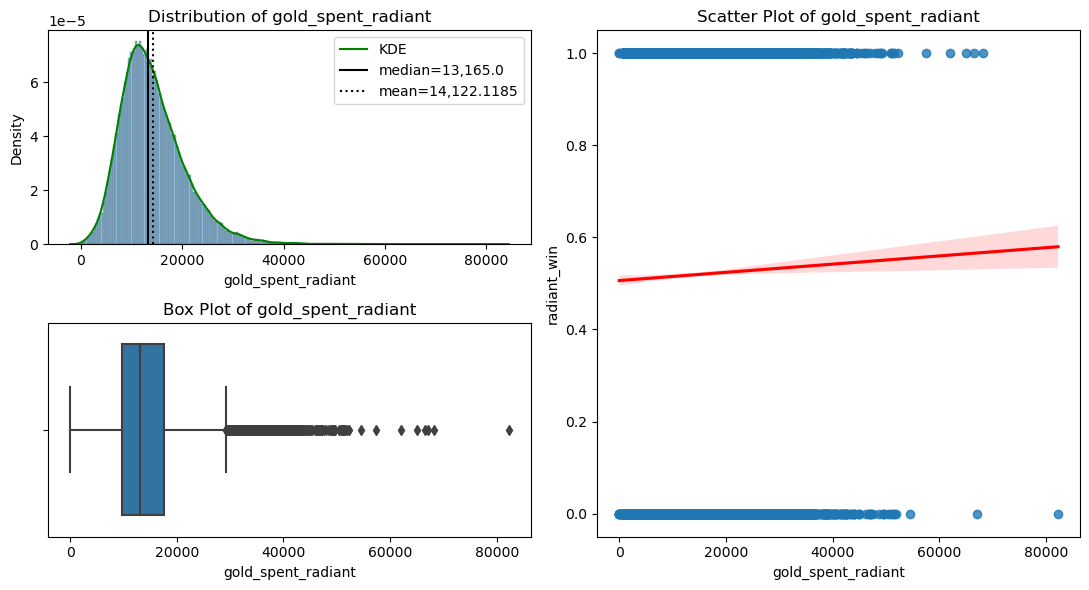

In [15]:
visual_eda(data_matches, 'radiant_win', 'gold_spent_radiant');

In [31]:
def evaluate_model(model, X_train, y_train, X_test, y_test, digits=4, 
                   figsize=(10,5), params=False): 
        
    # Get Predictions
    y_hat_test = model.predict(X_test)
    y_hat_train = model.predict(X_train)
    
    # Classification Report / Scores 

    print("TRAINING DATA")
    
    print(metrics.classification_report(y_train,y_hat_train, digits=digits))
    

    print("TEST DATA")
    
    print(metrics.classification_report(y_test,y_hat_test, digits=digits))

    print("CONFUSION MATRIX AND ROC-AUC")

    
    fig, axes = plt.subplots(ncols=2, 
                             figsize=figsize)
    
    # Confusion Matrix
    metrics.plot_confusion_matrix(model, X_test,
                                  y_test,normalize='true',
                                 cmap='Purples',ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    
    # Plot ROC Curve
    metrics.plot_roc_curve(model,X_test,y_test,ax=axes[1])

    ax = axes[1]
    ax.legend()
    ax.plot([0,1],[0,1], ls='-')
    ax.grid()
    ax.set_title('ROC AUC Curve')
    
    plt.tight_layout()
    plt.show()
    
    if params == True:
        print("MODEL PARAMETERS")
        params = pd.DataFrame(pd.Series(model.get_params()))
        params.columns=['parameters']
        display(params)
    return y_hat_test

In [32]:
from sklearn.preprocessing import StandardScaler

def split_scale(df, target, scaler=StandardScaler()):
    # Separate X and y
    y = df[target]
    X = df.drop(target, axis=1)

    # Ensure that X contains only numeric data
    X = X.select_dtypes(include=[np.number])

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    # Get list of column names
    cols = X_train.columns

    # Scale columns
    scaler = scaler
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=cols)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=cols)

    return X_train, X_test, y_train, y_test

In [33]:
def fit_eval(model, X_train, y_train, X_test, y_test, digits=4, 
             figsize=(10,5), params=False):
    
    model.fit(X_train, y_train)

    pred=evaluate_model(model, X_train, y_train, X_test, y_test, digits=digits, 
                   figsize=figsize, params=params)
    
    return model,pred

In [34]:
# Create Training and Test Data Splits.
from sklearn.model_selection import train_test_split

# Correct the target variable name from 'radian_win' to 'radiant_win'
x_train, x_test, y_train, y_test = split_scale(data_matches, 'radiant_win')

TRAINING DATA
              precision    recall  f1-score   support

       False     0.9940    0.9932    0.9936     18038
        True     0.9937    0.9945    0.9941     19462

    accuracy                         0.9938     37500
   macro avg     0.9938    0.9938    0.9938     37500
weighted avg     0.9938    0.9938    0.9938     37500

TEST DATA
              precision    recall  f1-score   support

       False     0.9952    0.9910    0.9931      6019
        True     0.9917    0.9955    0.9936      6481

    accuracy                         0.9934     12500
   macro avg     0.9934    0.9933    0.9933     12500
weighted avg     0.9934    0.9934    0.9934     12500

CONFUSION MATRIX AND ROC-AUC


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


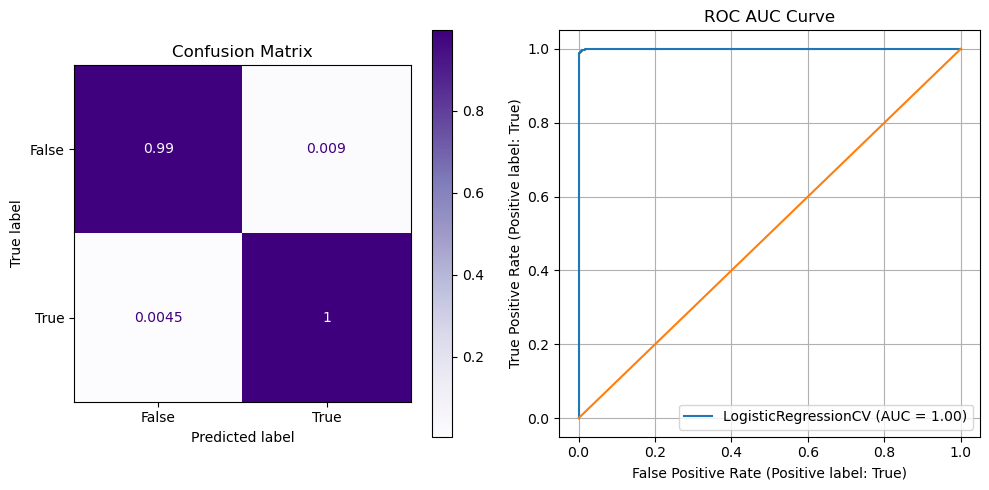

In [35]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
log,pred = fit_eval(LogisticRegressionCV(random_state=42), x_train, y_train, x_test, y_test)